<style>
  body.notebook_app {
    font-family: 'Open Sans', sans-serif, 'Arial', 'Helvetica';
  }
  .project-header-custom {
    background-color: #2d6df6; /* o el color que prefieras para este notebook */
    color: white;
    padding: 25px;
    border-radius: 8px;
    margin-bottom: 30px;
    position: relative;
    font-family: 'Open Sans', sans-serif, 'Arial', 'Helvetica';
  }
  .project-header-custom h1,
  .project-header-custom p,
  .project-header-custom li {
    color: white !important;
    font-family: 'Open Sans', sans-serif, 'Arial', 'Helvetica';
  }
  .project-header-custom .logo-container {
    position: right; 
    top: 25px;         
    right: 25px;       
  }
  .project-header-custom .logo-container img {
    width: 120px;
    height: auto;
    border-radius: 5px;
  }
</style>

<div class="project-header-custom">
  <div class="logo-container">
    <img src="../images/Logo_Prueba.png" alt="Logo del Proyecto"/>
  </div>
  <h1>BRAIN-CANCER-AI-PIPELINE: 03 - Modelo de Recomendación de Tratamiento</h1>
  <p><strong>Autor:</strong> Juan Pablo Restrepo Urrea</p>
  <p><strong>Fecha:</strong> Fecha Actual</p>
</div>

## Resumen del Notebook

Este notebook detalla el proceso de desarrollo, evaluación y análisis del modelo de recomendación de tratamiento para pacientes con tumores cerebrales. Su objetivo principal es predecir el tratamiento más adecuado (`chemotherapy`, `close monitoring`, `radiation therapy`, `surgery`) basándose en características clínicas del paciente, síntomas procesados y, crucialmente, la clasificación del tipo de tumor obtenida de un modelo de visión previo (desarrollado en el Notebook 02).

Las fases principales cubiertas son:

1.  **Configuración del Entorno y Carga de Librerías:** Inicialización de rutas, importación de todas las dependencias necesarias (`pandas`, `numpy`, `sklearn`, `xgboost`, `shap`, módulos `src`) y fijación de una semilla para garantizar la reproducibilidad de los resultados.
2.  **Carga y Preparación de Datos:** Lectura del dataset clínico previamente procesado, codificación de etiquetas para las variables objetivo y auxiliares, y división estratificada del conjunto de datos en entrenamiento y prueba.
3.  **Preprocesamiento de Características y Optimización del Modelo (XGBoost):**
    *   Construcción de un pipeline de preprocesamiento robusto para manejar diferentes tipos de características (numéricas, sintomáticas, categóricas - incluyendo el tipo de tumor).
    *   Aplicación de la técnica SMOTE (Synthetic Minority Over-sampling Technique) al conjunto de entrenamiento para abordar el desequilibrio inherente en las clases de la variable `treatment`.
    *   Ajuste fino (tuning) de los hiperparámetros del clasificador XGBoost mediante un proceso de búsqueda aleatorizada y validación cruzada, utilizando el `F1-score ponderado` como métrica principal de optimización.
4.  **Entrenamiento y Evaluación del Pipeline de Recomendación Integrado:**
    *   Guardado del modelo XGBoost optimizado y del preprocesador de características para su uso futuro.
    *   Simulación de un flujo de inferencia realista: primero, se infiere la condición del tumor para el conjunto de prueba utilizando el modelo de clasificación de imágenes (EfficientNet del Notebook 02).
    *   Posteriormente, esta condición inferida, junto con las demás características clínicas, se utiliza para predecir el tratamiento mediante el modelo XGBoost.
    *   Cálculo de métricas de rendimiento detalladas (reporte de clasificación, accuracy global) y visualización de la matriz de confusión para el pipeline completo.
5.  **Análisis Avanzado del Rendimiento y Explicabilidad del Modelo:**
    *   Comparación del rendimiento del pipeline con un escenario "ideal" donde se utiliza la condición real del tumor (en lugar de la predicha), para cuantificar el impacto del modelo de clasificación de imágenes en la recomendación de tratamiento.
    *   Análisis de la importancia de las características para identificar los predictores más influyentes según el modelo XGBoost.
    *   Interpretación del comportamiento del modelo utilizando valores SHAP, para entender cómo las diferentes características contribuyen a las predicciones de tratamiento para instancias individuales y a nivel global.

---
### Reflexión sobre el Proceso de Modelado y Enfoque Adoptado

El desarrollo del sistema de recomendación de tratamiento fue un proceso iterativo que comenzó con un exhaustivo Análisis Exploratorio de Datos (EDA) y un preprocesamiento detallado, incluyendo la transformación de notas clínicas en características estructuradas. Se investigaron diversas estrategias para maximizar la precisión predictiva, tales como la ingeniería avanzada de características (combinaciones polinómicas, interacciones) y el uso de modelos de lenguaje como ClinicalBERT para el procesamiento de texto.

En la fase de modelado, se evaluaron algoritmos de clasificación basados en árboles y ensambles (Random Forest, LightGBM, XGBoost) y se exploraron técnicas para manejar el desequilibrio de clases en la variable `treatment`, como SMOTE. Consistentemente, el `F1-score ponderado` fue la métrica principal para la optimización y evaluación.

A pesar de esta exploración exhaustiva, se observó un "techo" en el rendimiento predictivo, atribuido a las limitaciones inherentes del conjunto de datos disponible más que a las técnicas de modelado. Factores clínicos no capturados en el dataset (biomarcadores, estado funcional detallado, etc.) probablemente influyen significativamente en las decisiones de tratamiento del mundo real.

Dada esta meseta de rendimiento y la necesidad de un modelo práctico, se consolidó el enfoque en un clasificador **XGBoost**. Esta elección se basó en su rendimiento consistente durante las pruebas, su robustez, y su capacidad para manejar el desequilibrio de clases (finalmente abordado con SMOTE en la etapa de entrenamiento). El modelo XGBoost optimizado se integra en un pipeline donde la predicción del tipo de tumor (de un modelo de visión previo) es una característica de entrada clave, siendo la `condicion_tumoral` el predictor más influyente según los análisis de importancia y SHAP. El rendimiento final del pipeline, aunque modesto, se considera representativo de lo alcanzable con los datos actuales.

---


---
## 1. Configuración del Entorno y Carga de Librerías
En esta sección inicial, se configura el entorno de ejecución. Esto incluye la detección automática de la ruta raíz del proyecto para permitir la importación correcta de módulos locales desde la carpeta `src`. Posteriormente, se importan todas las librerías esenciales para el flujo de trabajo, como `pandas` para la manipulación de datos, `numpy` para operaciones numéricas, `sklearn` para tareas de machine learning (división de datos, métricas), `xgboost` para el modelo de clasificación, `joblib` para guardar/cargar modelos, `matplotlib` y `seaborn` para visualizaciones, y `shap` para la explicabilidad del modelo. Finalmente, se establece una semilla global (`SEED`) para garantizar la reproducibilidad de los resultados en todas las ejecuciones.

In [1]:

import os
os.environ['SCIPY_ARRAY_API'] = '1'

from pathlib import Path
import sys, warnings
HERE = Path().resolve()
for p in [HERE, *HERE.parents]:
    if (p / "src").is_dir():
        PROJECT_ROOT = p
        break
else:
    raise RuntimeError("No se encontró carpeta 'src'")
sys.path.insert(0, str(PROJECT_ROOT))

import numpy as np
import pandas as pd
import torch
import joblib
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

from src.config import (
    PROCESSED_DATA_PATH,
    MODEL_TUMOR_CLASSIFIER_PATH,
    SEED, BATCH_SIZE, NUM_CLASSES_CONDITION, MODEL_DIR
)
from src.utils import seed_everything
from src.data_preprocessing import build_clinical_preprocessor, label_encode_column
from src.image_processing import predict_conditions
from src.model_training import tune_xgb_classifier, get_model
from src.evaluation import plot_confusion_matrix

seed_everything(SEED)
warnings.filterwarnings("ignore")


c:\Users\juanreur\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---
## 2. Carga y Preparación Inicial de Datos
Se carga el DataFrame procesado, producto del notebook anterior (`01_EDA_and_Preprocessing.ipynb`), que contiene las características clínicas y las rutas a las imágenes. Se eliminan filas con valores nulos en columnas críticas como `image_path`, `condition` y `treatment` para asegurar la integridad de los datos.

A continuación, se realiza la codificación de etiquetas (Label Encoding) para las variables categóricas objetivo (`condition` y `treatment`), transformándolas a un formato numérico que el modelo pueda procesar. La variable `sex` también se mapea a un código numérico (`sex_code`).

Finalmente, el conjunto de datos se divide estratificadamente en un conjunto de entrenamiento (80%) y un conjunto de prueba (20%). La estratificación se realiza sobre la variable `treatment_code` para asegurar que la proporción de cada tipo de tratamiento se mantenga en ambas divisiones. Se muestran las distribuciones de la variable `treatment` en los conjuntos de entrenamiento y prueba para verificar la correcta estratificación.

In [2]:

df = pd.read_csv(PROCESSED_DATA_PATH).dropna(
    subset=["image_path","condition","treatment"]
)
print(f"📄  Dataset total: {len(df)} filas")
# ─────────────────────────────—— label encoding  +  save encoders ────────────
df, le_cond  = label_encode_column(df, "condition")
df, le_treat = label_encode_column(df, "treatment")
df["sex_code"] = df["sex"].str.upper().map({"M": 0, "F": 1})

#guardar los encoders para el pipeline de inferencia
encoders_dict = {"condition": le_cond, "treatment": le_treat}
MODEL_DIR.mkdir(parents=True, exist_ok=True)
joblib.dump(encoders_dict, MODEL_DIR / "label_encoders.joblib")
print("✔️  LabelEncoders guardados en:", MODEL_DIR / "label_encoders.joblib")

# ───────────────────── estratified split ─────────────────────────────────────
num_feats = ["age", "duration_days", "sex_code"]
sym_feats = [c for c in df.columns if c.startswith("sym_")]
cat_feats = ["condition_code"]
feature_cols = num_feats + sym_feats + cat_feats

tr, te = train_test_split(
    df,
    test_size   = 0.20,
    stratify    = df["treatment_code"],
    random_state= SEED
)
print(f"🔹 Train: {len(tr)}   🔸 Test: {len(te)}")

print("\nDistribución Treatment en Train:")
print(tr["treatment"].value_counts(normalize=True) * 100)

print("\nDistribución Treatment en Test:")
print(te["treatment"].value_counts(normalize=True) * 100)



📄  Dataset total: 6012 filas
✔️  LabelEncoders guardados en: C:\Users\juanreur\Downloads\Reto Tecnico Biociencias\brain-cancer-ai-pipeline\models\label_encoders.joblib
🔹 Train: 4809   🔸 Test: 1203

Distribución Treatment en Train:
treatment
radiation therapy    31.274693
surgery              30.546891
chemotherapy         19.401123
close monitoring     18.777293
Name: proportion, dtype: float64

Distribución Treatment en Test:
treatment
radiation therapy    31.338321
surgery              30.507066
chemotherapy         19.368246
close monitoring     18.786367
Name: proportion, dtype: float64


---
## 3. Preprocesamiento, Manejo de Desequilibrio y Ajuste Fino del Modelo
Esta sección se centra en la preparación de los datos de entrenamiento para el modelo XGBoost y en la optimización de sus hiperparámetros.

**3.1. Preprocesador de Características Clínicas:**
Se construye un `ColumnTransformer` de `sklearn` para aplicar transformaciones específicas a diferentes tipos de características:
*   **Características Numéricas (`age`, `duration_days`, `sex_code`):** Se escalan utilizando `MinMaxScaler`.
*   **Características de Síntomas (`sym_*`):** También se escalan con `MinMaxScaler`.
*   **Características Categóricas (`condition_code`):** Se aplica `OneHotEncoder`.
Este preprocesador se ajusta (`fit_transform`) sobre los datos de entrenamiento.

**3.2. Manejo del Desequilibrio con SMOTE:**
Dado el desequilibrio observado en las clases de la variable `treatment`, se aplica la técnica SMOTE (Synthetic Minority Over-sampling Technique) exclusivamente al conjunto de entrenamiento preprocesado. SMOTE genera instancias sintéticas de las clases minoritarias para balancear la distribución de clases, lo que puede ayudar al modelo a aprender mejor de estas clases menos representadas. Se verifica la nueva distribución de clases después de aplicar SMOTE.

**3.3. Ajuste Fino de Hiperparámetros de XGBoost:**
Se realiza una búsqueda aleatorizada de hiperparámetros (`tune_xgb_classifier`) para el clasificador XGBoost utilizando el conjunto de entrenamiento balanceado con SMOTE. La búsqueda se realiza durante un número definido de iteraciones (`n_iter`) y se evalúa mediante validación cruzada (`cv_splits`). La métrica objetivo para la optimización es `f1_weighted`, adecuada para problemas multiclase desequilibrados. Se especifica si se debe utilizar GPU para el entrenamiento. Finalmente, se muestran los mejores parámetros encontrados y el mejor `F1-score ponderado` obtenido en la validación cruzada.

In [ ]:

preproc = build_clinical_preprocessor(num_feats, sym_feats, cat_feats, scaler="minmax")
X_tr = preproc.fit_transform(tr[feature_cols])
y_tr = tr["treatment_code"].values

X_tr_sm, y_tr_sm = SMOTE(random_state=SEED).fit_resample(X_tr, y_tr)
print("\nTras SMOTE, conteos:")
print(pd.Series(y_tr_sm).map(lambda i: le_treat.inverse_transform([i])[0]).value_counts())


xgb_best, best_params, best_cv = tune_xgb_classifier(
    X_tr_sm, y_tr_sm,
    n_iter=30, cv_splits=3,
    scoring="f1_weighted",
    use_gpu=False,  
)
print("\n🏆 Mejores parámetros:")
print(best_params)
print(f"🏆 Mejor F1_weighted CV: {best_cv:.4f}")


=== Best params === {'n_estimators': 875, 'learning_rate': np.float64(0.08926168509217601), 'max_depth': 10, 'min_child_weight': 8, 'gamma': np.float64(0.21605560280045127), 'subsample': np.float64(0.7160556028004512), 'colsample_bytree': np.float64(0.7160556028004512), 'colsample_bylevel': np.float64(0.7160556028004512), 'colsample_bynode': np.float64(0.7160556028004512), 'reg_alpha': np.float64(0.43211120560090255), 'reg_lambda': np.float64(0.43211120560090255), 'max_delta_step': 7}
Best CV f1_weighted: 0.4246

🏆 Mejores parámetros:
{'n_estimators': 875, 'learning_rate': np.float64(0.08926168509217601), 'max_depth': 10, 'min_child_weight': 8, 'gamma': np.float64(0.21605560280045127), 'subsample': np.float64(0.7160556028004512), 'colsample_bytree': np.float64(0.7160556028004512), 'colsample_bylevel': np.float64(0.7160556028004512), 'colsample_bynode': np.float64(0.7160556028004512), 'reg_alpha': np.float64(0.43211120560090255), 'reg_lambda': np.float64(0.43211120560090255), 'max_delta

---
## 4. Entrenamiento del Pipeline Completo y Evaluación en el Conjunto de Prueba
Con los mejores hiperparámetros identificados y el preprocesador ajustado, se procede a construir y evaluar el pipeline completo de recomendación de tratamiento.

**4.1. Guardado de Artefactos del Modelo:**
El modelo XGBoost optimizado (`xgb_best`) y el preprocesador de características clínicas (`preproc`) se guardan en disco utilizando `joblib` para su posterior uso o despliegue.

**4.2. Inferencia de la Condición del Tumor en el Conjunto de Prueba:**
Para simular un escenario realista donde el tipo de tumor no se conoce a priori, se utiliza el modelo de clasificación de imágenes (entrenado en el notebook `02_MRI_Tumor_Classification_Model.ipynb` y guardado en `MODEL_TUMOR_CLASSIFIER_PATH`) para predecir la `condition_code` para cada instancia del conjunto de prueba. Esta predicción de la condición se incorpora a los datos de prueba.

**4.3. Predicción del Tratamiento y Evaluación:**
Las características del conjunto de prueba (incluyendo la `condition_code` inferida) se transforman utilizando el preprocesador ajustado. Luego, el modelo XGBoost optimizado se utiliza para predecir el `treatment_code`.
Se evalúa el rendimiento del pipeline completo comparando las predicciones (`y_hat_pipe`) con las etiquetas verdaderas (`y_true`) del conjunto de prueba. Se genera un reporte de clasificación detallado (precisión, recall, F1-score por clase, y promedios) y se calcula la accuracy global del pipeline. Adicionalmente, se visualiza una matriz de confusión para analizar en detalle los patrones de aciertos y errores del modelo.


📊 Métricas Pipeline:
                   precision    recall  f1-score   support

     chemotherapy       0.27      0.30      0.29       233
 close monitoring       0.24      0.24      0.24       226
radiation therapy       0.33      0.34      0.33       377
          surgery       0.28      0.25      0.26       367

         accuracy                           0.29      1203
        macro avg       0.28      0.28      0.28      1203
     weighted avg       0.29      0.29      0.29      1203

Accuracy pipeline: 0.286783042394015


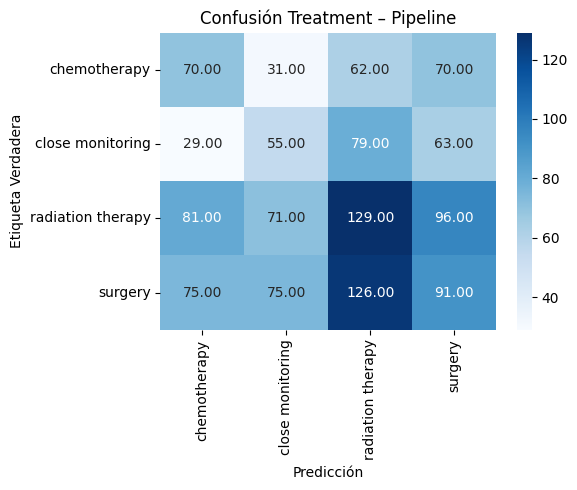

In [ ]:

MODEL_DIR.mkdir(exist_ok=True)
joblib.dump(xgb_best, MODEL_DIR/"treatment_xgb_tuned.joblib")
joblib.dump(preproc, MODEL_DIR/"treatment_preproc.joblib")


cond_preds = predict_conditions(te, MODEL_TUMOR_CLASSIFIER_PATH)
te_proc = te[feature_cols].copy()
te_proc["condition_code"] = cond_preds
X_te   = preproc.transform(te_proc)


y_hat_pipe = xgb_best.predict(X_te)
y_true    = te["treatment_code"].values

print("\n📊 Métricas Pipeline:")
print(classification_report(
    y_true, y_hat_pipe,
    target_names=le_treat.classes_
))
print("Accuracy pipeline:", accuracy_score(y_true, y_hat_pipe))


plot_confusion_matrix(
    le_treat.inverse_transform(y_true),
    le_treat.inverse_transform(y_hat_pipe),
    class_names=le_treat.classes_,
    title="Confusión Treatment – Pipeline"
)


**Resumen del Rendimiento del Pipeline de Recomendación de Tratamiento**

El pipeline final para recomendar tratamiento muestra un **rendimiento general modesto**, con una **accuracy global de aproximadamente 28.7%** y **F1-scores (macro y ponderado) alrededor de 0.29**.

**Observaciones Clave:**

*   **Por Clase:** El modelo funciona ligeramente mejor para "Radioterapia" (F1-score: 0.33) y tiene mayores dificultades con "Seguimiento Cercano" (F1-score: 0.24).
*   **Matriz de Confusión:**
    *   "Radioterapia" es la clase con más aciertos (129) pero también es una predicción incorrecta frecuente para otros tratamientos.
    *   "Seguimiento Cercano" es la clase peor identificada (55 aciertos), confundiéndose a menudo con "Radioterapia" y "Cirugía".
    *   Existe una tendencia general del modelo a confundir otros tratamientos con "Radioterapia" y "Cirugía".

**Conclusión:**
El rendimiento limitado refleja probablemente el "techo" impuesto por la información contenida en el actual conjunto de datos para esta compleja tarea. Aunque se exploraron múltiples enfoques, la calidad y riqueza de los datos son factores determinantes. Las mejoras significativas requerirían probablemente datos más informativos o características adicionales.

---
## 5. Análisis de Rendimiento y Explicabilidad del Modelo
Para obtener una comprensión más profunda del comportamiento del modelo de recomendación de tratamiento, se realizan análisis adicionales.

**5.1. Evaluación en Escenario Ideal (Control):**
Se evalúa el rendimiento del modelo XGBoost utilizando la **condición real del tumor** del conjunto de prueba, en lugar de la condición predicha por el modelo de imágenes. Esto establece un "techo" o rendimiento ideal para el modelo de recomendación, asumiendo una clasificación perfecta del tipo de tumor. La diferencia (`Δ pérdida cond`) entre esta accuracy ideal y la accuracy del pipeline completo cuantifica la pérdida de rendimiento atribuible a los errores del modelo de clasificación de imágenes.

**5.2. Importancia de Características:**
Se extraen y visualizan las importancias de las características según el modelo XGBoost. Esto ayuda a identificar qué variables tienen mayor influencia en las predicciones del tratamiento. Las características se presentan en una tabla y un gráfico de barras con el top 10.

**5.3. Análisis con Valores SHAP (SHapley Additive exPlanations):**
Se utiliza la librería `shap` para calcular los valores SHAP para el conjunto de prueba. Los valores SHAP proporcionan una medida de la contribución de cada característica a la predicción para cada instancia individual. Se genera un `SHAP summary plot`, que visualiza la distribución de los valores SHAP para cada característica, mostrando tanto la magnitud como la dirección del impacto de cada una en las predicciones del modelo.

Accuracy ideal: 0.28512053200332504
Δ pérdida cond: -0.0016625103906899308

Top 10 Features:
                       feature  importance
18           condition_code_1    0.247118
17           condition_code_0    0.146307
19           condition_code_2    0.047804
1               duration_days    0.038132
13  sym_neurological_weakness    0.037457
10         sym_memory_problem    0.037353
0                         age    0.035238
8                 sym_fatigue    0.034889
7                sym_dizzines    0.033436
9                 sym_headach    0.032620


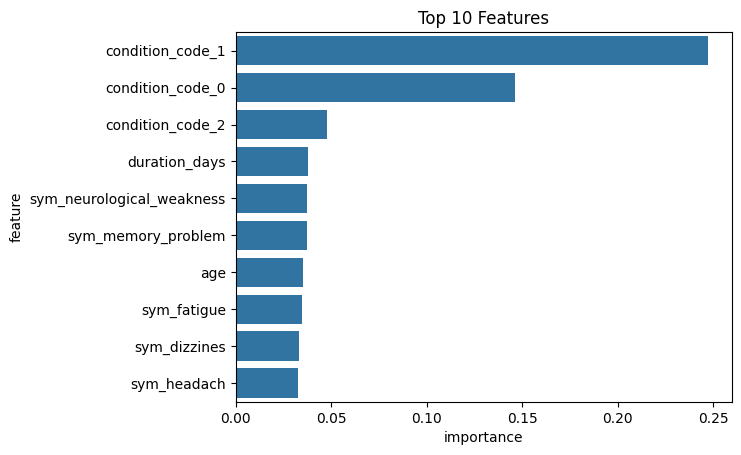

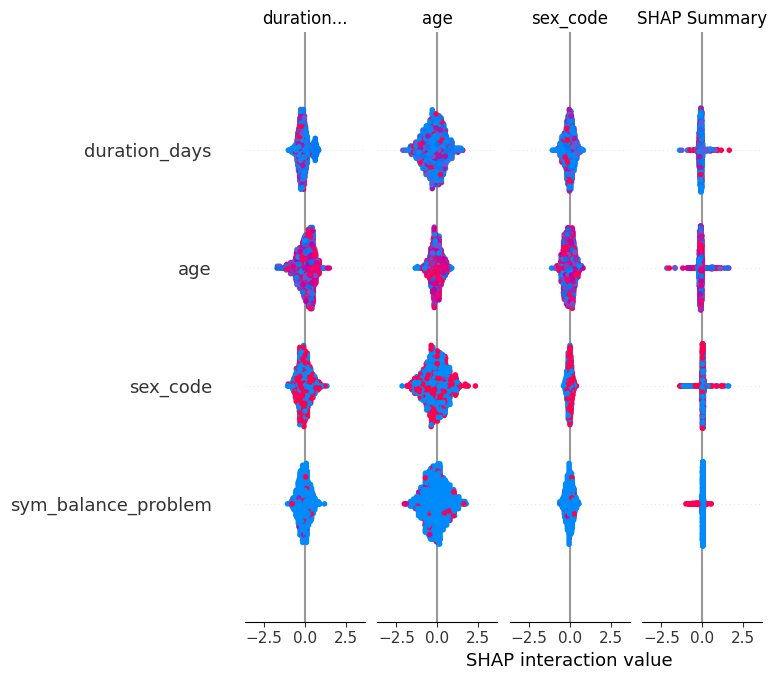

In [ ]:

X_te_real = preproc.transform(te[feature_cols])
y_hat_ideal = xgb_best.predict(X_te_real)
print("Accuracy ideal:", accuracy_score(y_true, y_hat_ideal))
print("Δ pérdida cond:", accuracy_score(y_true, y_hat_ideal) - accuracy_score(y_true, y_hat_pipe))

feat_names = num_feats + sym_feats + preproc.named_transformers_["cat"].get_feature_names_out(cat_feats).tolist()
importances = xgb_best.feature_importances_
fi_df = pd.DataFrame({"feature":feat_names,"importance":importances}).sort_values("importance",ascending=False)
print("\nTop 10 Features:\n", fi_df.head(10))
sns.barplot(data=fi_df.head(10), x="importance", y="feature"); plt.title("Top 10 Features"); plt.show()


import shap
explainer = shap.TreeExplainer(xgb_best)
shap_values = explainer.shap_values(pd.DataFrame(X_te, columns=feat_names))
shap.summary_plot(shap_values, pd.DataFrame(X_te, columns=feat_names), show=False)
plt.title("SHAP Summary"); plt.show()


**Análisis de Importancia de Características y Valores SHAP del Modelo de Recomendación de Tratamiento**

**Importancia de Características (Top 10 Features):**

El gráfico de "Top 10 Features" muestra la importancia relativa de las características según el modelo XGBoost para predecir el tratamiento.

*   **Dominancia de la Condición del Tumor (`condition_code_X`):**
    *   Las características más importantes son, con diferencia, las relacionadas con el tipo de tumor: `condition_code_1` (importancia ~0.247), `condition_code_0` (importancia ~0.146) y `condition_code_2` (importancia ~0.048). Estos códigos representan las diferentes categorías de tumores (ej. Glioma, Meningioma, Otro Tumor) después de la codificación one-hot o similar.
    *   Esto confirma la fuerte intuición y los hallazgos del EDA: el tipo de tumor es el predictor individual más potente para determinar el tratamiento. El modelo se basa principalmente en esta información.

*   **Características Secundarias Relevantes:**
    *   `duration_days` (duración de los síntomas) aparece como la cuarta característica más importante (importancia ~0.038). Esto sugiere que la cronicidad de los síntomas también juega un papel, aunque menor que el tipo de tumor.
    *   Síntomas Específicos: Varios síntomas individuales aparecen en el top 10, aunque con importancias considerablemente menores que la condición del tumor:
        *   `sym_neurological_weakness` (~0.037)
        *   `sym_memory_problem` (~0.037)
        *   `sym_fatigue` (~0.035)
        *   `sym_dizzines` (~0.034)
        *   `sym_headach` (~0.033)
    *   `age` (edad del paciente) también figura en el top 10 (importancia ~0.035), indicando que, si bien el EDA mostró perfiles de edad similares entre tratamientos, la edad aún aporta cierta información al modelo, aunque de forma secundaria.

*   **Implicaciones:** La alta dependencia del modelo en el tipo de tumor (`condition_code_X`) es esperada y clínicamente relevante. La menor importancia de otros síntomas individuales y características demográficas podría indicar que su poder predictivo es más sutil o que su influencia está modulada por el tipo de tumor.

**Análisis de Valores SHAP (Interacciones y Resumen):**

El gráfico de interacciones SHAP (SHAP interaction value) y el SHAP Summary (no completamente visible, pero se infiere su naturaleza) proporcionan una visión más profunda de cómo cada característica influye en la predicción para cada clase de tratamiento (aunque la imagen no especifica para qué clase de tratamiento es el SHAP plot, asumimos que es un resumen o para una clase específica).

*   **`duration_days`:**
    *   **SHAP Summary (columna derecha):** Los puntos azules (valores bajos de `duration_days`) tienden a tener valores SHAP negativos (empujan la predicción hacia una clase), mientras que los puntos rojos (valores altos de `duration_days`) tienden a tener valores SHAP positivos (empujan la predicción hacia otra clase, o la misma con más fuerza). Esto sugiere una relación direccional.
    *   **Interacciones:** La interacción de `duration_days` con otras variables muestra patrones complejos. Por ejemplo, con `age`, parece haber diferentes tendencias según el valor de `duration_days`.

*   **`age`:**
    *   **SHAP Summary:** Hay una mezcla de puntos rojos y azules a lo largo del eje SHAP, indicando que tanto edades altas como bajas pueden influir positiva o negativamente en la predicción, y esta influencia no es linealmente simple.
    *   **Interacciones:** Su interacción con `duration_days` y `sex_code` es visible, mostrando cómo el impacto de la edad puede cambiar dependiendo de los valores de estas otras características.

*   **`sex_code`:**
    *   **SHAP Summary:** Los puntos rojos (un sexo) y azules (el otro sexo) se distribuyen a ambos lados del cero SHAP, pero sin una separación clara y fuerte, lo que sugiere un impacto modesto o contextual en las predicciones, consistente con el EDA bivariado.

*   **`sym_balance_problem`:**
    *   **SHAP Summary:** La presencia (puntos rojos) de `sym_balance_problem` parece tener un impacto predominantemente positivo en los valores SHAP (empujando hacia una predicción específica), mientras que su ausencia (puntos azules) tiene un impacto negativo. Esto indica que es una característica con una influencia direccional más clara para la predicción de ciertos tratamientos.

**Conclusiones Generales de SHAP e Importancia:**

*   **Validación del EDA:** Los resultados de importancia y SHAP refuerzan los hallazgos del EDA. El tipo de tumor (`condition_code_X`) es el factor dominante. Características como `duration_days` y síntomas específicos como `sym_neurological_weakness` o `sym_balance_problem` también aportan, pero su influencia es secundaria o más dependiente del contexto (interacciones).
*   **Complejidad de las Influencias:** Los gráficos SHAP, especialmente los de interacción, revelan que el impacto de una característica en la predicción del tratamiento no siempre es simple o lineal. El modelo XGBoost está capturando estas relaciones más complejas y las interdependencias entre variables.
*   **Explicabilidad del Modelo (Limitada por la Imagen):** Los valores SHAP comienzan a abrir la "caja negra" del modelo, mostrando cómo y por qué se toman ciertas decisiones a nivel de característica individual e interacciones, aunque un análisis completo requeriría SHAP plots para cada clase de tratamiento y un estudio más detallado.
*   **Consistencia con el Rendimiento del Modelo:** El hecho de que pocas características tengan una importancia abrumadoramente alta (aparte de `condition_code`) y que las influencias SHAP sean a menudo mixtas, podría estar relacionado con el rendimiento modesto del modelo. Si muchas características tuvieran impactos SHAP fuertes y consistentes, el modelo probablemente tendría una mayor capacidad de discriminación.